In [1]:
from datetime import datetime
from pathlib import Path


from energy_box_control.power_hub.control import control_power_hub, initial_control_state
from energy_box_control.power_hub.network import PowerHub, PowerHubSchedules
from energy_box_control.schedules import ConstSchedule
from datetime import timedelta, timezone
from energy_box_control.power_hub.control import initial_control_all_off

import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import os

# look for root, makes this cell idempotent
while not Path("pyproject.toml").is_file():
  os.chdir('..')


%load_ext autoreload 
%autoreload 2

sns.set_style("whitegrid")



In [7]:
from energy_box_control.appliances.base import ThermalState
from energy_box_control.appliances.water_maker import WaterMakerState, WaterMakerStatus, WaterMakerTankStatus
from energy_box_control.appliances.water_treatment import WaterTreatmentPort, WaterTreatmentState
from energy_box_control.monitoring.monitoring import Monitor


def simulate_powerhub(power_hub: PowerHub, control_function, steps: int, start_time: datetime = datetime.now(), step_size: timedelta = timedelta(seconds = 1), survival=False, no_water=False, checks=[]) -> tuple[pd.DataFrame, pd.DataFrame]:
    monitor = Monitor(sensor_value_checks=checks, url_health_checks=[])
    state = power_hub.simple_initial_state(start_time, step_size)
    if survival:
        state = state.replace_signal(power_hub.water_treatment, WaterTreatmentPort.OUT, ThermalState(0, float("nan")))

    if no_water:
        state = state.replace_state(power_hub.water_maker, WaterMakerState(WaterMakerStatus.STANDBY.value, WaterMakerTankStatus.FULL.value))
        state = state.replace_state(power_hub.water_treatment, WaterTreatmentState(False))
    control_state = initial_control_state()
    control_state.setpoints.survival_mode = survival
    control_values = initial_control_all_off(power_hub)

    control_results = {}
    results = {}
    for _ in range(steps):
        state = power_hub.simulate(state, control_values)

        sensors = power_hub.sensors_from_state(state)

        control_state, control_values = control_function(power_hub, 
            control_state, sensors, state.time.timestamp 
        )

        errors = monitor.run_sensor_value_checks(
            sensors,
            "notebook",
            control_values,
            power_hub
        )
        if errors != []:
            raise Exception(errors)

        control_results[state.time.timestamp] = pd.DataFrame(
            {**{
                key: item.__dict__ 
                for key, item in control_values.name_to_control_values_mapping( 
                    power_hub
                ).items() if item.__dict__ 
            },**{'control_mode':{key: item.control_mode._value_ for key, item in control_state.__dict__.items() if key != 'setpoints'}}} 
            
        ).T.stack()

        results[state.time.timestamp] = pd.DataFrame(sensors.to_dict()).T.stack()

    control_data = pd.DataFrame(control_results).T
    data = pd.DataFrame(results).T

    return (data, control_data)

In [8]:
schedules = PowerHubSchedules.schedules_from_data()
power_hub = PowerHub.power_hub(schedules)
# steps = 7*24
# step_size = timedelta(seconds = 60*60)

#schedules = PowerHubSchedules.const_schedules()
step_size = timedelta(seconds = 60)
steps = int(timedelta(days=1) / step_size)

In [9]:
def switch_stamps(control_modes, control_type):
    control_switch = control_modes[control_type] != control_modes[control_type].shift(1)
    modes = control_modes[control_switch][control_type].to_frame()
    intervals = modes.reset_index(names="start_stamp").join(
        modes.reset_index(names="end_stamp").shift(-1)["end_stamp"]
    )
    intervals.at[intervals.index[-1], "end_stamp"] = control_modes.index[-1]
    return intervals


def plot(appliances, data, powers, temperatures, control_modes):
    fig, axs = plt.subplots(len(appliances), 2, sharex = True, figsize = (20,30))


    for i, appliance in enumerate(appliances):
        axs[i,0] = data[powers][appliance].plot(ax = axs[i,0], legend = False, title = appliance + ' power')
        axs[i,1] = data[temperatures][appliance].plot(ax = axs[i,1], legend = False, title = appliance + ' temperature')

        if appliance in ["heat_pipes", "hot_reservoir", "pcm"]:
            control_type = "hot_control"
        elif appliance in ["yazaki", "chiller", "cold_reservoir"]:
            control_type = "chill_control"
        elif appliance in ["preheat_reservoir"]:
            control_type = "preheat_control"
        elif appliance in ["outboard_exchange"]:
            control_type = "waste_control"
        else: control_type = None 

        if control_type:
            stamps = switch_stamps(control_modes, control_type)
            colors = {k:sns.color_palette()[i] for i,k in enumerate(stamps[control_type].unique())}
            for min, mode, max in stamps.itertuples(index = False):
                axs[i,0].axvspan(min, max, alpha = .2, label = mode, color = colors[mode])
                axs[i,1].axvspan(min, max, alpha = .2, label = mode, color = colors[mode])

        for ax in axs[i]:
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), loc = "best")
        
    plt.tight_layout()

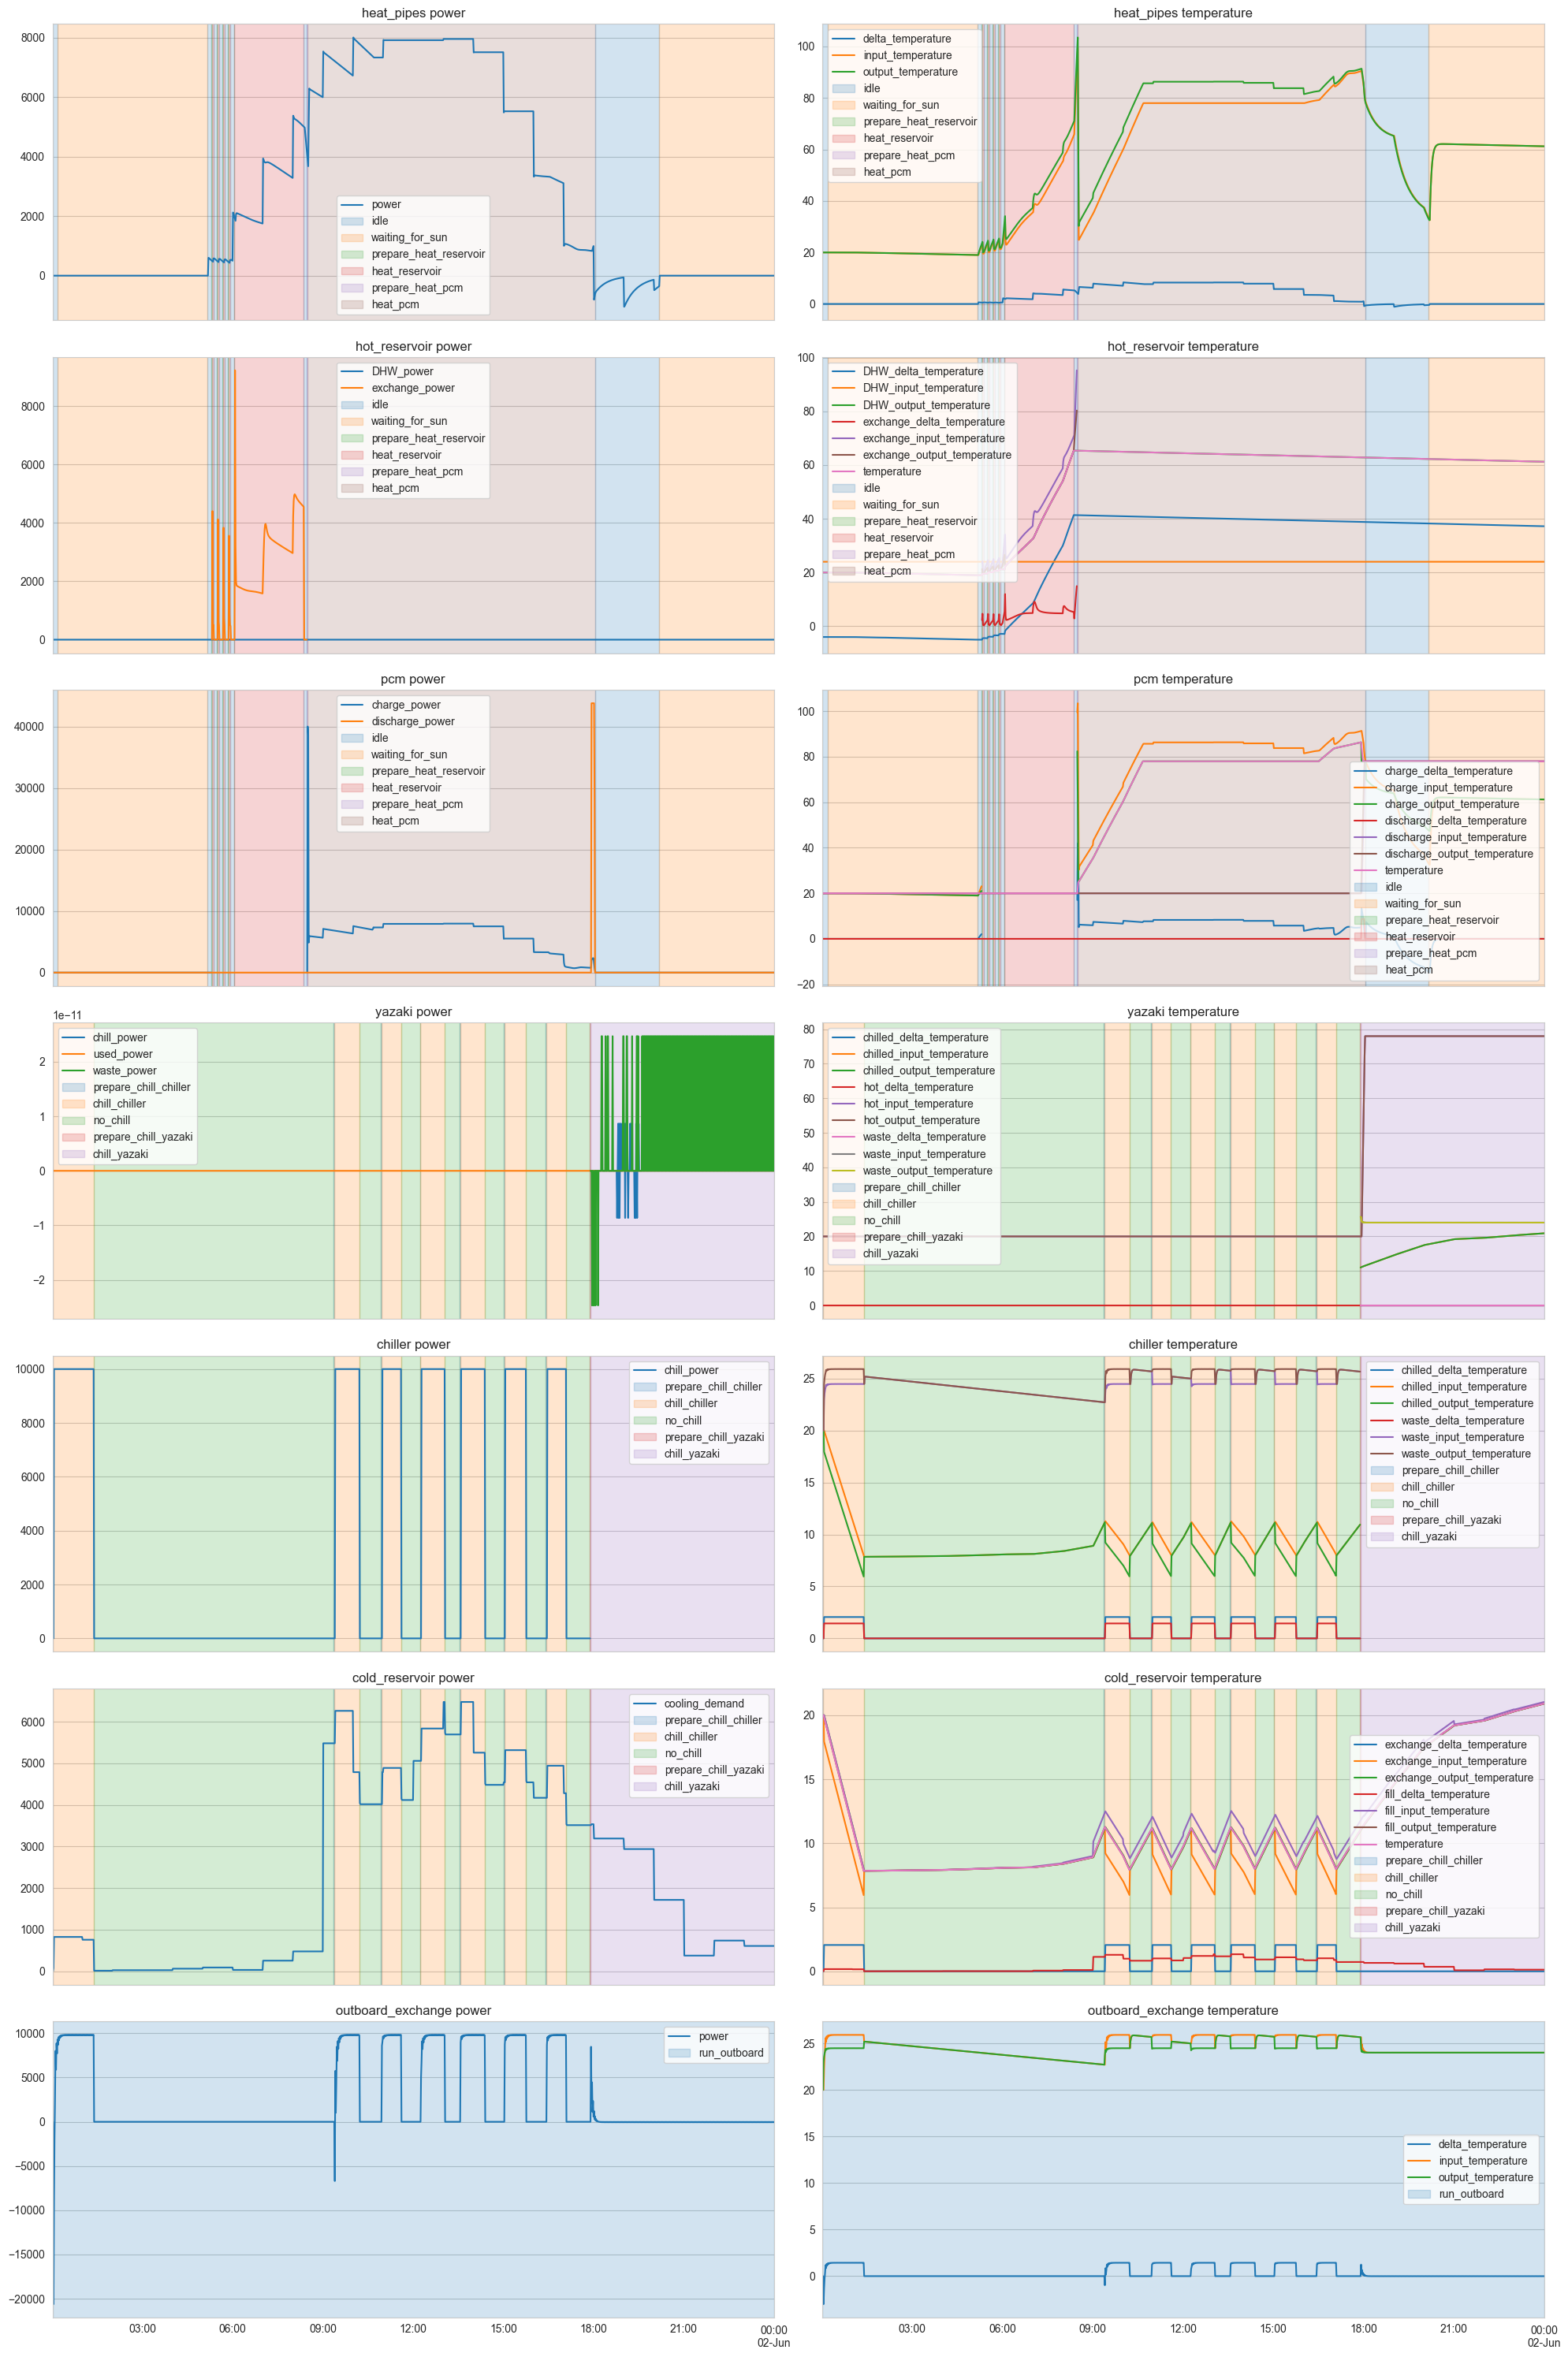

In [10]:
data, control_data = simulate_powerhub(power_hub, control_power_hub, steps, datetime(2017,6,1,0,0,0, tzinfo=timezone.utc), step_size)
appliances = ["heat_pipes", "hot_reservoir", "pcm", "yazaki", "chiller", "cold_reservoir", "outboard_exchange"]
temperatures = [(appliance,var) for appliance, var in data.columns if 'temperature' in var and appliance in appliances]
powers = [(appliance,var) for appliance, var in data.columns if 'power' in var and appliance in appliances] + [('cold_reservoir','cooling_demand') + ('cold_reservoir','cooling_supply') + ('preheat_reservoir',None)]

control_modes = control_data["control_mode"]

plot(appliances, data, powers, temperatures, control_modes)

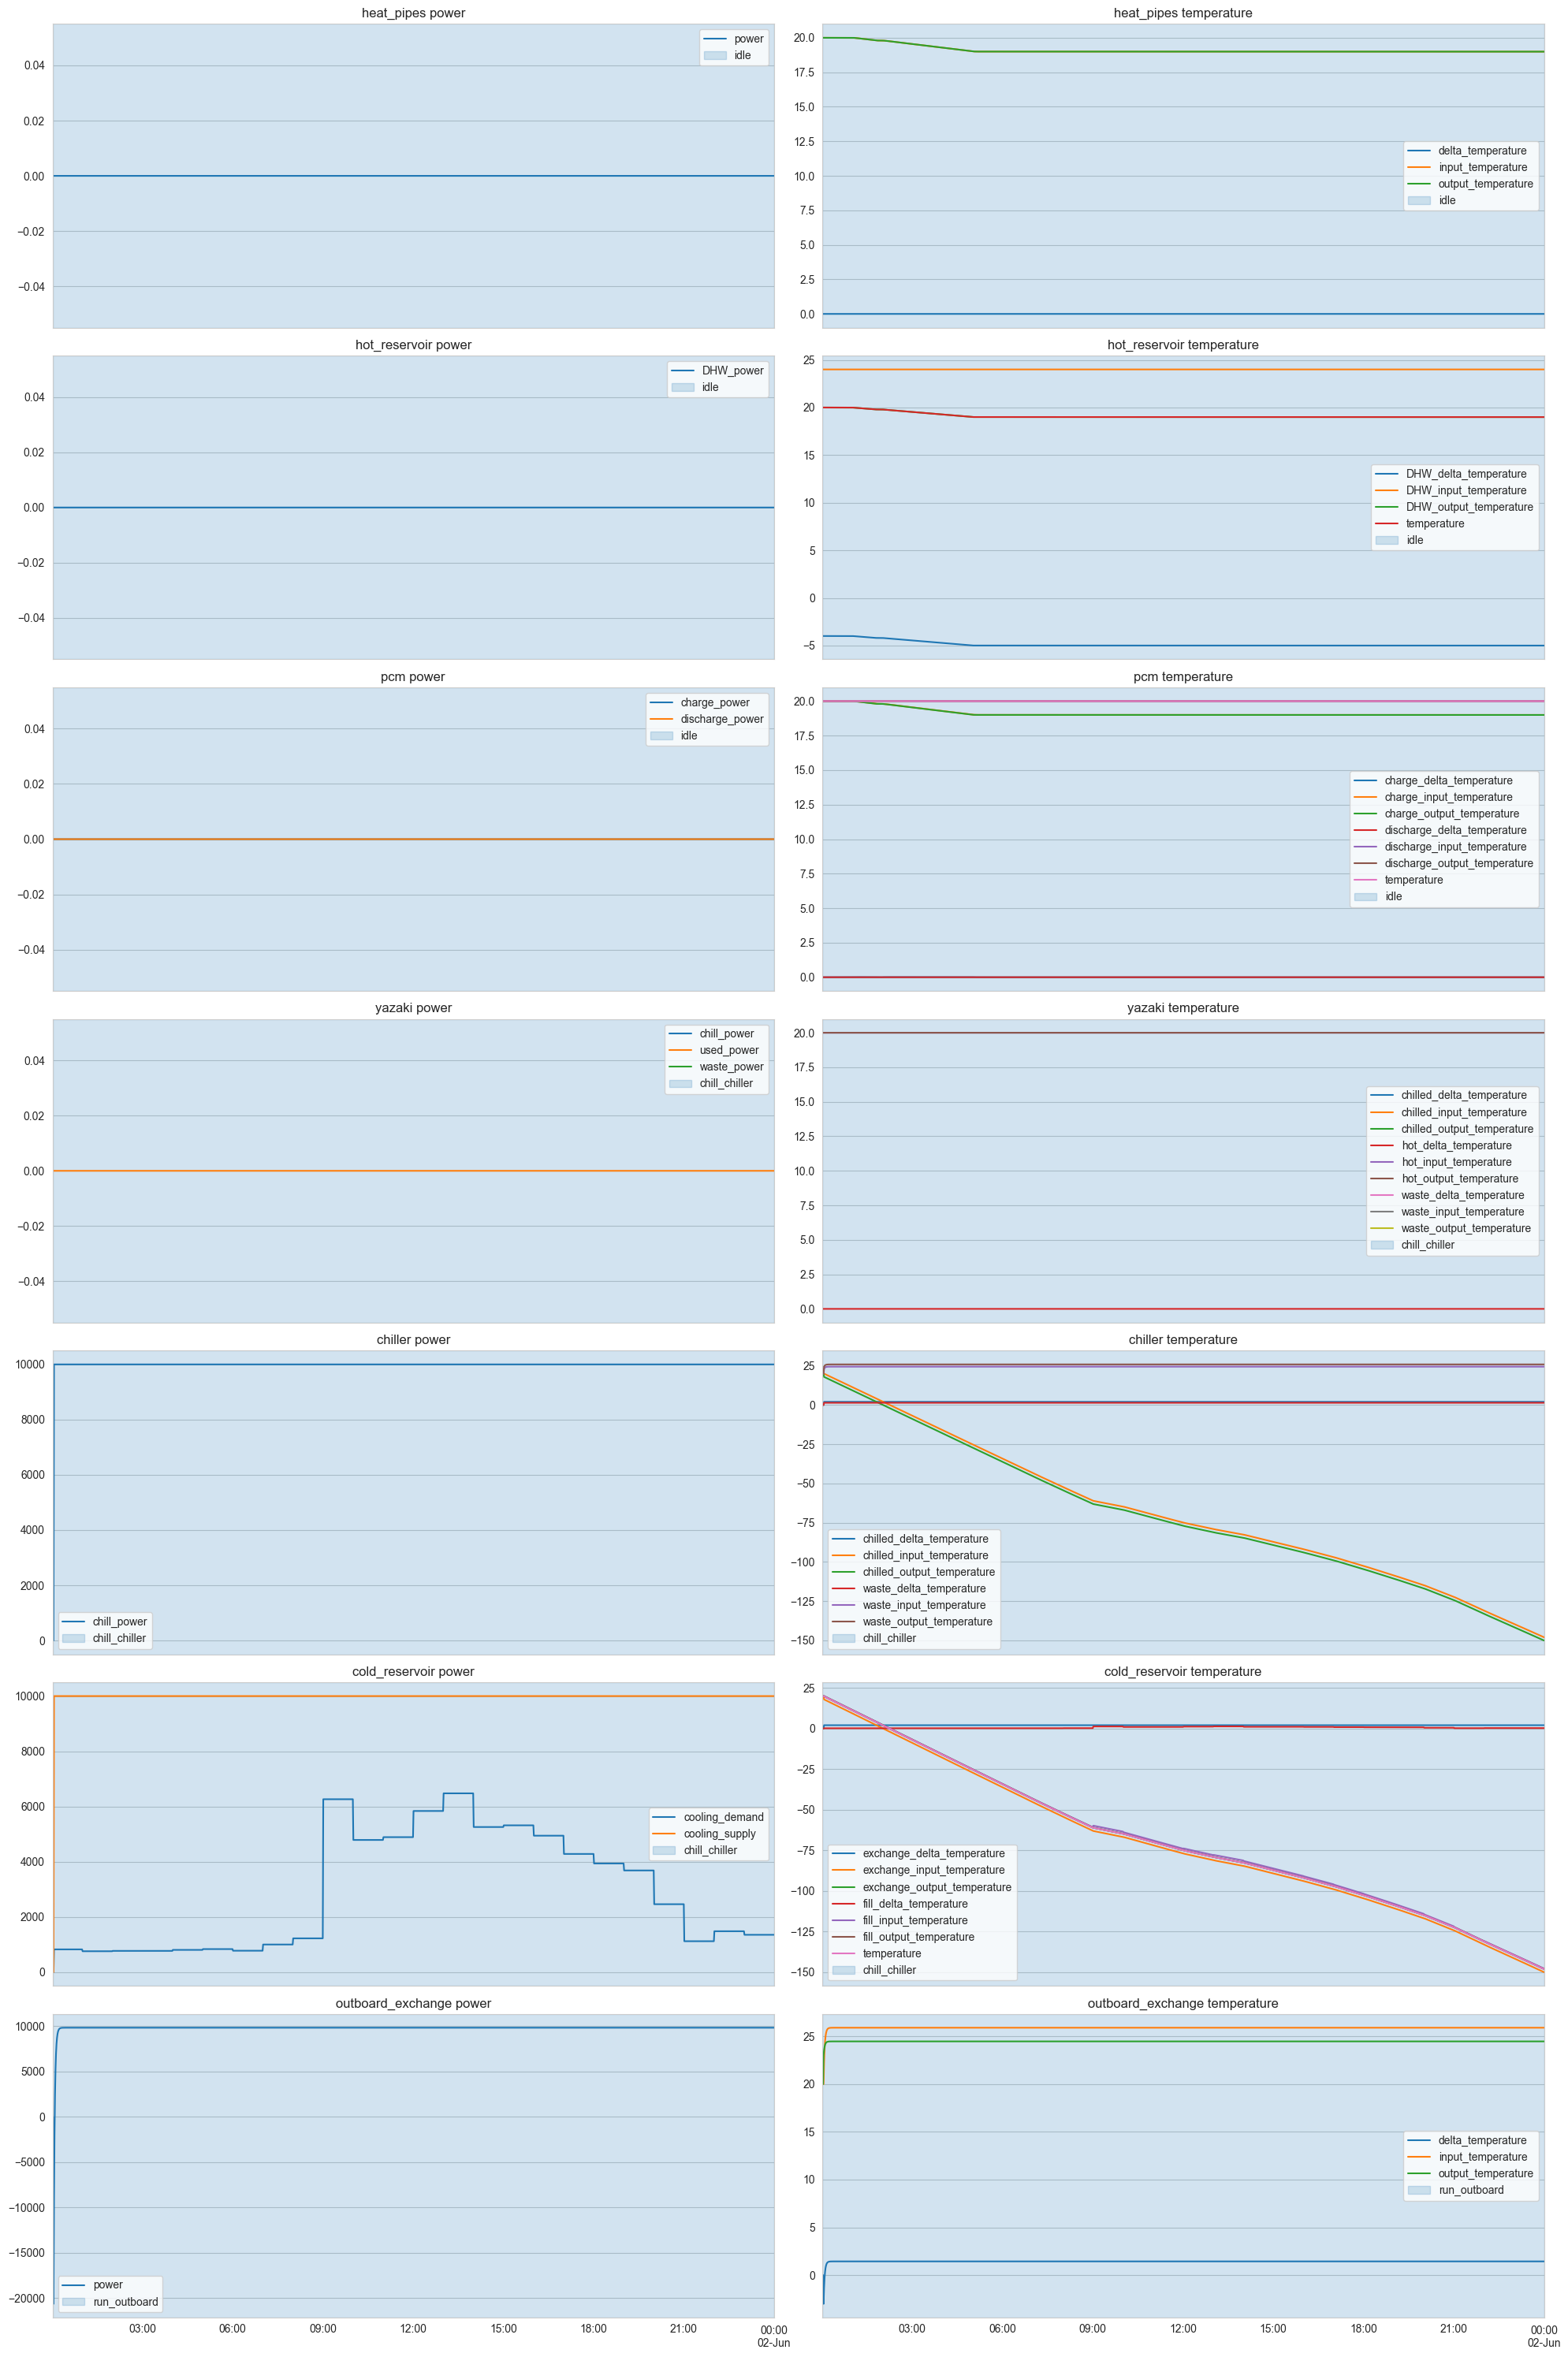

In [11]:
from dataclasses import replace


no_fresh_water_demand_schedules = replace(schedules, fresh_water_demand=ConstSchedule(0))
no_water_schedules = replace(no_fresh_water_demand_schedules, grey_water_supply=ConstSchedule(0))
power_hub_no_water = PowerHub.power_hub(no_water_schedules)

data, control_data = simulate_powerhub(
    power_hub_no_water,
    control_power_hub,
    steps,
    datetime(2017, 6, 1, 0, 0, 0, tzinfo=timezone.utc),
    step_size,
    survival=True,
    no_water=True,
)
appliances = [
    "heat_pipes",
    "hot_reservoir",
    "pcm",
    "yazaki",
    "chiller",
    "cold_reservoir",
    "outboard_exchange",
]
temperatures = [
    (appliance, var)
    for appliance, var in data.columns
    if "temperature" in var and appliance in appliances
]
powers = [(appliance,var) for appliance, var in data.columns if 'power' in var and appliance in appliances] + [('cold_reservoir','cooling_demand'), ('cold_reservoir','cooling_supply')]

control_modes = control_data["control_mode"]

plot(appliances, data, powers, temperatures, control_modes)

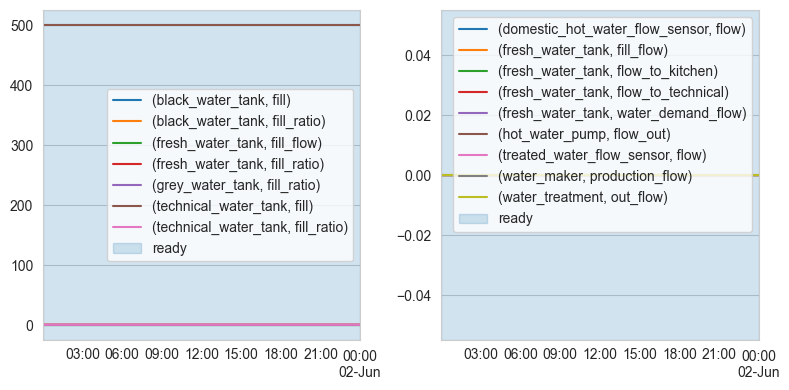

In [12]:
water_appliances = [appliance for appliance, _ in data.columns if 'water' in appliance]
fills = [(appliance,var) for appliance, var in data.columns if 'fill' in var and appliance in water_appliances]
flows = [(appliance,var) for appliance, var in data.columns if 'flow' in var and appliance in water_appliances]

control_modes = control_data['control_mode']

fig, axs = plt.subplots(1, 2, sharex = True, figsize = (8,4))

axs[0] = data[fills].plot(ax = axs[0])
axs[1] = data[flows].plot(ax = axs[1])

control_type = 'water_control'

if control_type:
    stamps = switch_stamps(control_modes, control_type)
    colors = {k:sns.color_palette()[i] for i,k in enumerate(stamps[control_type].unique())}
    for min, mode, max in stamps.itertuples(index = False):
        axs[0].axvspan(min, max, alpha = .2, label = mode, color = colors[mode])
        axs[1].axvspan(min, max, alpha = .2, label = mode, color = colors[mode])

for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc = "best")

plt.tight_layout()

